In [2]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib nbagg

# Definitions and Data

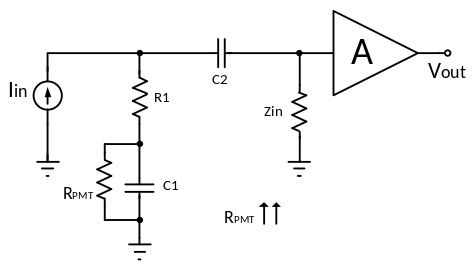

In [3]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_PMT.png")

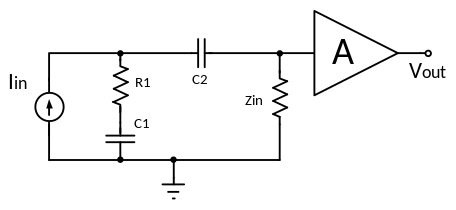

In [4]:
Image(filename = PATH + "FEE_PMT_simple.png")

$$\frac{v_O}{i_I}=\frac{Z_{in}}{(1+\frac{C_1}{C_2})}\frac{1+R_1C_1s}{1+\frac{(R_1+R_2)C_1}{(1+\frac{C1}{C2})}s} = \frac{Z_{in}}{(1+\frac{C_1}{C_2})}.\frac{1}{1+\frac{(R_1+R_2)C_1}{(1+\frac{C_1}{C_2})}s} + \frac{R_1R_2}{R_1+R_2}.\frac{\frac{(R_1+R_2)C_1}{1+\frac{C_1}{C_2}}s}{1+\frac{(R_1+R_2)C_1}{1+\frac{C_1}{C_2}}s}$$

In [5]:
f_sample = (1/25E-9); # Hz

C1=2714E-9
C2=8.0E-9
R1=1567; 
Zin=62; 
MEASURED_GAIN = 582.237
A=MEASURED_GAIN/(R1*Zin/(R1+Zin))
GAIN=(R1*Zin/(R1+Zin))*A 
# Seems stupid. It's just to remember true GAIN measured in simulation 

freq_zero=1/(R1*C1); print 'Zero(Hz) =',freq_zero/(2*np.pi)
freq_HPF=1/((R1+Zin)*C1/(1+C1/C2)); print 'HPF(kHz) =',freq_HPF/(1E3*2*np.pi)
freq_LPF1=3E6*2*np.pi;print 'LPF1(MHz) =',freq_LPF1/(1E6*2*np.pi)
freq_LPF2=10E6*2*np.pi;print 'LPF2(MHz) =',freq_LPF2/(1E6*2*np.pi)

freq_zerod= freq_zero / (f_sample*np.pi) ; print 'Zero(rad/sec) =',freq_zero,'// (half-cycles/sample) =',freq_zerod
freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d


Zero(Hz) = 37.4232319905
HPF(kHz) = 12.2486249791
LPF1(MHz) = 3.0
LPF2(MHz) = 10.0
Zero(rad/sec) = 235.13710139 // (half-cycles/sample) = 1.87116159952e-06
HPF(rad/sec) = 76960.3805021 // (half-cycles/sample) = 0.000612431248957
LPF1(rad/sec) = 18849555.9215 // (half-cycles/sample) = 0.15
LPF2(rad/sec) = 62831853.0718 // (half-cycles/sample) = 0.5


In [6]:
GAIN_b=A

b1, a1 = signal.butter(1, freq_HPFd, 'high', analog=False); 
b2, a2 = signal.butter(1, freq_HPFd, 'low', analog=False);

b_aux = b2*(Zin/(1+C1/C2))+b1*(Zin*R1/(Zin+R1))
a_aux = a1 

b1l, a1l = signal.butter(1, freq_LPF1d, 'low', analog=False); 
b2l, a2l = signal.butter(4, freq_LPF2d, 'low', analog=False);
b_auxl = np.convolve(b1l,b2l); a_auxl = np.convolve(a1l,a2l);

b = GAIN_b*np.convolve(b_auxl,b_aux); a = np.convolve(a_auxl,a_aux);


# (b / a) ARE THE COEFFICIENTS OF THE FILTER WE USE TO MODEL THE FEE_PMT

<IPython.core.display.Javascript object>


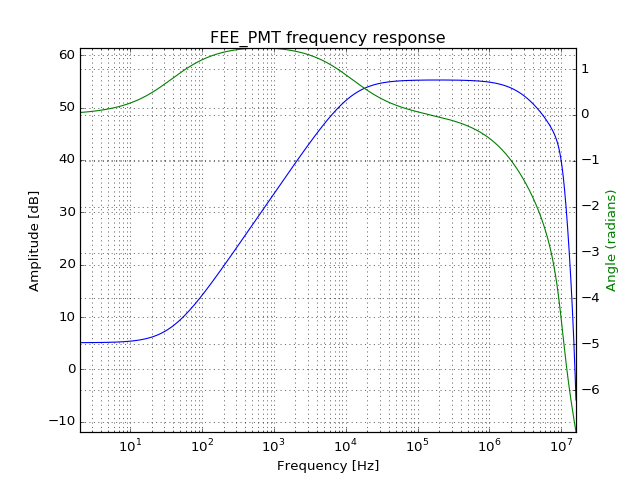

In [7]:

w, h = signal.freqz(b, a, worN=np.logspace(-6.5,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
fig = plt.figure(2)
ax1 = fig.add_subplot(111)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.semilogx(w*(f_sample)/(2*np.pi), angles,'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')

plt.show()

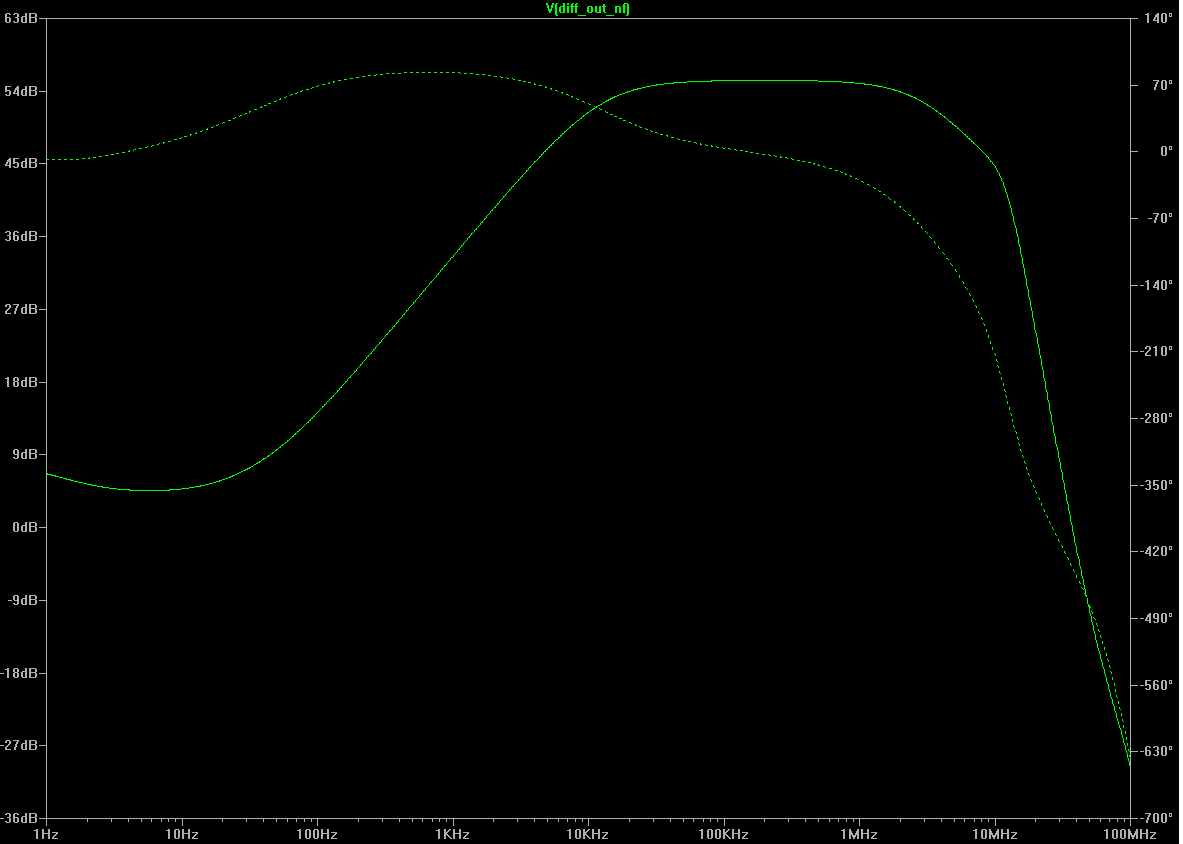

In [8]:
Image(filename = PATH + "FEE_PMT_freq_response_simulated_spice.png")

# VERY CLOSE TO THE SPICE SIMULATED ONE

In [9]:
signal_in = np.concatenate((np.zeros((1,1000)),np.ones((1,4000)),np.zeros((1,20000))),axis=1)
signal_out = signal.lfilter(b,a,signal_in[0,0:])

<IPython.core.display.Javascript object>


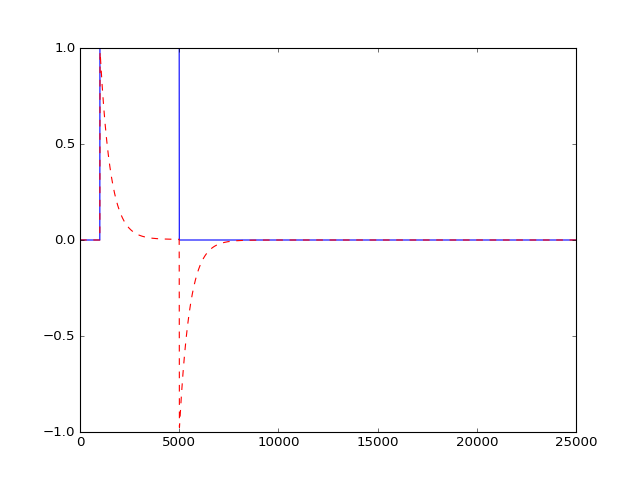

25000


In [10]:
plt.figure(1)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(signal_in),1),signal_out/GAIN,'r--', linewidth=1)
plt.show()

# DECONVOLUTION USING ONLY BLR

<IPython.core.display.Javascript object>


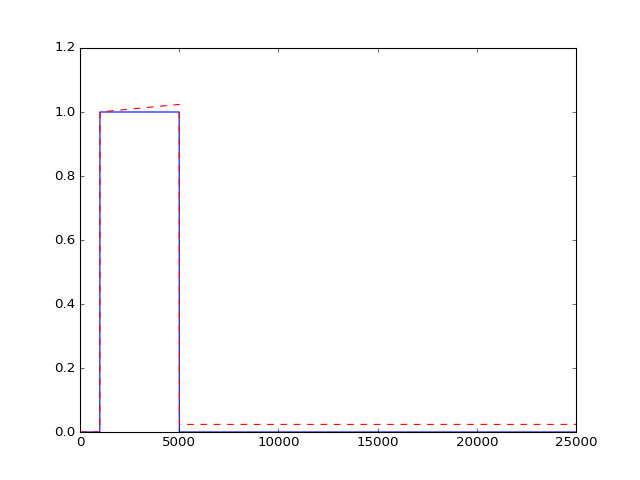

Input Energy = 4000.0
Reconstructed Energy = 4044.06697057
Error in Energy Computation (%) =  -1.10167426419


In [11]:
recons=BLRc(signal_daq=signal_out,coef=freq_HPFd*np.pi,thr1 = 0.01)/GAIN
plt.figure(3)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
plt.plot(range(0,np.size(recons),1),recons,'r--', linewidth=1)
plt.show()
energy_mea=np.sum(recons[1000:5000])
print 'Input Energy =', np.sum(signal_in)
print 'Reconstructed Energy =', energy_mea
print 'Error in Energy Computation (%) = ', (np.sum(signal_in)-energy_mea)/np.sum(signal_in)*100

# DECONVOLUTION USING CLEANING FILTER + BLR

In [12]:
b_cf, a_cf = signal.butter(1, freq_zerod, 'high', analog=False);

## (b_cf / a_cf) ARE THE COEFFICIENTS OF THE CLEANING FILTER

In [13]:
signal_out_cf = signal.lfilter(b_cf,a_cf,signal_out)

In [14]:
recons2=BLRc(signal_daq=signal_out_cf,coef=freq_HPFd*np.pi,thr1 = 0.01)/GAIN

<IPython.core.display.Javascript object>


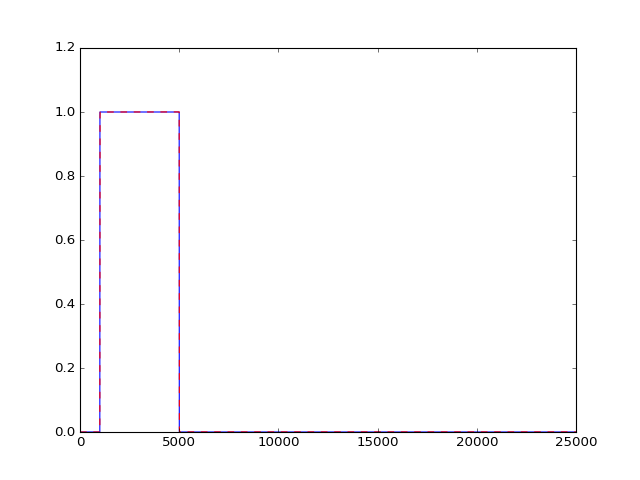

Input Energy = 4000.0
Reconstructed Energy = 3997.1152413
Error in Energy Computation (%) =  0.0721189675382


In [15]:
plt.figure(4)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
plt.plot(range(0,np.size(recons2),1),recons2,'r--', linewidth=1)
plt.show()
energy_mea2=np.sum(recons2[1000:5000])
print 'Input Energy =', np.sum(signal_in)
print 'Reconstructed Energy =', energy_mea2
print 'Error in Energy Computation (%) = ', (np.sum(signal_in)-energy_mea2)/np.sum(signal_in)*100

# ... and this is an extreme worst case!!!

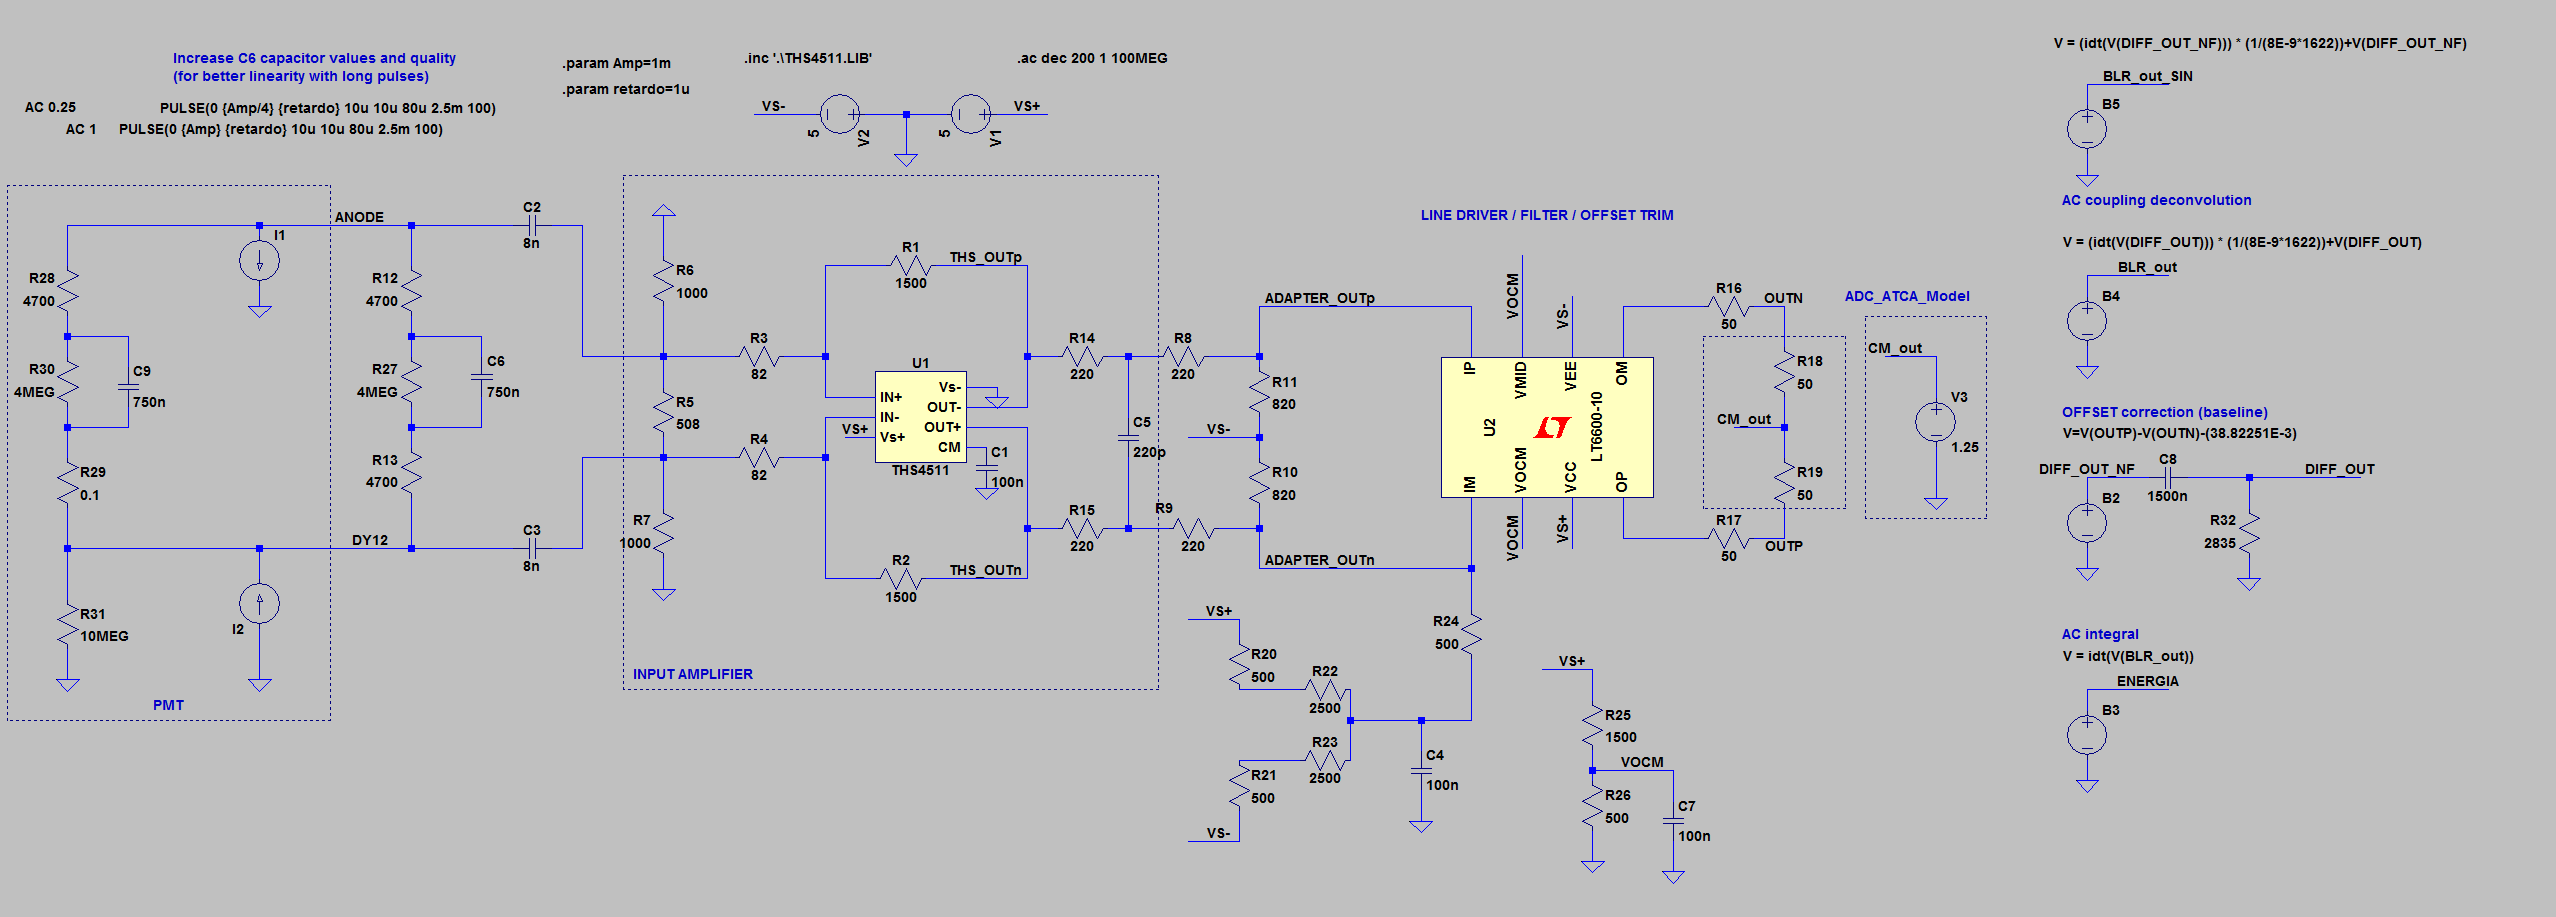

In [16]:
Image(filename = PATH + "FULL_sch.png")